# <center>Trabajo Práctico 1: Reservas de Hotel</center>
# <center>Checkpoint 4</center>

## <center>Organización de Datos</center>
#### <center>Cátedra Ing. Rodriguez, Juan Manuel </center>

Grupo 32 - Kung Fu Pandas

Integrantes:
* Daniel Agustin Marianetti - Padrón: 106256
* Franco Rodriguez - Padrón: 102815
* Ezequiel Lazarte - Padrón: 108063

Importamos las librerias que vamos a utilizar

In [1]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.2 MB/s eta 0:00:00


In [2]:
!pip install keras==2.12.0
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)


In [3]:
#Gral.
import pandas as pd
import numpy as np
import joblib

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


#Metricas
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score

#Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils.vis_utils import plot_model
# import visualkeras
from scipy.stats import uniform, randint


np.random.seed(1010)
tf.random.set_seed(1010)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_train_procesado = pd.read_csv('/content/drive/MyDrive/datasetsTP/hotels_train_procesado.csv')
df_trabajo = df_train_procesado.copy()

df_test_procesado = pd.read_csv('/content/drive/MyDrive/datasetsTP/hotels_test_procesado.csv')
df_trabajo_test = df_test_procesado.copy()

## Preprocesamiento

In [5]:
df_trabajo.drop(['meal', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'adults'], inplace=True, axis=1)
df_trabajo_test.drop(['meal', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'adults'], inplace=True, axis=1)

In [6]:
var_categoricas = set(['hotel', 'arrival_date_month',
                         'arrival_date_day_of_month', 'country',
                         'reserved_room_type', 'assigned_room_type',
                         'is_repeated_guest', 'deposit_type', 'agent',
                         'customer_type', 'distribution_channel', 'market_segment'])

label_encoder = preprocessing.LabelEncoder()

for col in df_trabajo.columns:
  if col in var_categoricas:
    df_trabajo[col] = label_encoder.fit_transform(df_trabajo[col])

for col in df_trabajo_test.columns:
  if col in var_categoricas:
    df_trabajo_test[col] = label_encoder.fit_transform(df_trabajo_test[col])

Aplicamos LabelEncoder a todas las variables que no sean numericas para poder utilizarlas

In [7]:
df_trabajo.drop(['id'], axis='columns', inplace=True)

# Obtengo los ids para agregarlos después y aprovecho a sacar la variable que no esta en el ds de train
ids_submit = df_trabajo_test['id']
df_trabajo_test.drop(['id', 'reservation_status_date'], axis='columns', inplace=True)

## Definición Set de Entrenamiento y Set de Test

In [8]:
df_trabajo_x = df_trabajo.drop('is_canceled', axis='columns')

df_trabajo_y = df_trabajo['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=1010) #semilla

# Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 42777
# Datos Prueba: 18334
% Positivos Entrenamiento: 50.025
% Positivos Prueba: 50.442


In [9]:
# Normalizo los datos de train y entreno el modelo, transformo los datos de test
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

df_trabajo_test_norm = stand_scaler.transform(df_trabajo_test)

##Funciones útiles

In [10]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  precision_modelo=precision_score(y_test,y_pred)
  accuracy_modelo=accuracy_score(y_test,y_pred)
  recall_modelo=recall_score(y_test,y_pred)
  f1_score_modelo=f1_score(y_test,y_pred)

  print("Precision: "+str(precision_modelo))
  print("Accuracy: "+str(accuracy_modelo))
  print("Recall: "+str(recall_modelo))
  print("F1-Score: "+str(f1_score_modelo))
  print()

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [11]:
def generar_df_submit_segun_proba(modelo, proba):

  prob_pred = modelo.predict(df_trabajo_test_norm)

  submit_pred = []
  for x in np.where(prob_pred > proba, 1, 0):
    submit_pred.append(x[0])

  df_submit = pd.DataFrame(zip(ids_submit,submit_pred),columns=['id','is_canceled'])

  return df_submit

Función para generar la predicción contra el conjunto brindado y crear un df que puede ser subido a la competencia de Kaggle

## Modelo 1

In [12]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

modelo_1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 37        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


In [14]:
import keras.backend as K

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
modelo_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01),
  loss='binary_crossentropy', # Loss function utilizada para clasificacion binaria
  metrics=[custom_f1], # metricas para ir calculando en cada iteracion o batch
)

cant_epochs_1=10
modelo_1_historia = modelo_1.fit(x_train_norm, y_train,
                                 epochs=cant_epochs_1,
                                 batch_size=50,
                                 verbose=False)

## Modelo 2 (CV optimizando conexiones con una layer)

Hacemos esta parte como un modelo distinto porque por la dimensionalidad de nuestros datos, no se puede entrenar la red con las conexiones que vienen a continuación con layers intermedias

In [16]:
# def conv2d_conexion(num_filters, kernel_size=(2, 2), activation='relu'):
#   return keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, activation=activation)

# def lstm_conexion(num_units, activation='tanh'):
#   return keras.layers.LSTM(num_units, activation=activation)

# def crear_modelo_conexiones(learning_rate=0.001, num_neurons=128,
#                  act_func = 'relu', funcion_info={'name': "conexion_conv2d", 'value': conv2d_conexion}):
#     model = keras.Sequential()

#     model.add(funcion_info["value"].(num_neurons, input_shape=(d_in,), activation='relu'))

#     model.add(keras.layers.Dense(1, activation='sigmoid'))

#     model.compile(
#         optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.6, beta_2=0.8, epsilon=1e-07),
#         loss='binary_crossentropy',
#         metrics=[custom_f1]
#     )
#     return model

# param_dist = {
#     'learning_rate': uniform(0.001, 0.01),
#     'num_neurons': [40, 80, 100, 120],  # Numero de neuronas por capa intermedia
#     'act_func': ['sigmoid', 'relu', 'tanh'], # Funcion de activacion de las capas intermedias
#     'funcion_info': [
#                      {'name': "conexion_conv2d", 'value': conv2d_conexion},
#                      {'name': "conexion_lstm", 'value': lstm_conexion},
#                     ]
# }

# model = KerasClassifier(build_fn=crear_modelo_conexiones, verbose=0)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=model, param_distributions=param_dist, scoring='f1_macro', cv=cv, n_iter=30, verbose=2, n_jobs=1
# )
# random_search.fit(x_train_norm, y_train)

# print("Best Parameters:")
# best_params = random_search.best_params_
# for param, value in best_params.items():
#     print(f"{param}: {value}")

In [17]:
# # Pasamos a este arreglo para poder usarlo como argumento y reutilizar el creador de modelo
# best_hypers = {
#     'learning_rate': best_params['learning_rate'],
#     'num_neurons': best_params['num_neurons'],
#     'act_func': best_params['act_func'],
#     'funcion_info': best_params['funcion_info']
#     }

# modelo_cv_conexiones = crear_modelo_conexiones(**best_hypers)

# #Probando a mano, obtuvimos buenos resultados con esta combinación de epochs y batch_size
# modelo_cv_conexiones.fit(x_train_norm, y_train, epochs=25, batch_size=300, verbose=False)

## Modelo 3 (CV optimizando layers con conexiones Dense)

Para optimizar hiperparámetros con CV, debemos para cada iteración crear una red neuronal. Para lograr esto, debemos definir una función que cree el mismo a partir de combinaciones distintas de hiperparámetros. Sumamos a esto, un pequeño trozo de lógica para lograr un efecto de "embudo" de neuronas, veremos tras el procesamiento si mejora resultados.

In [18]:
def dense_conexion(num_neurons, activation='relu'):
    return keras.layers.Dense(num_neurons, activation=activation)

def crear_modelo_layers(learning_rate=0.001, num_layers=2, num_neurons_hidden=128,
                 num_neurons_entry=128, act_func_hidden = 'sigmoid', act_func_entry = 'relu', reduccion=False):
    model = keras.Sequential()

    #input
    model.add(keras.layers.Dense(num_neurons_entry, input_shape=(d_in,), activation=act_func_entry))

    #ocultas
    for _ in range(num_layers):
        model.add(keras.layers.Dense(num_neurons_hidden, input_shape=(d_in,), activation=act_func_hidden))
        if(reduccion):
            num_neurons_hidden = num_neurons_hidden / 2

    #output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.6, beta_2=0.8, epsilon=1e-07),
        loss='binary_crossentropy',
        metrics=[custom_f1]
    )
    return model

param_dist = {
    'learning_rate': uniform(0.001, 0.01),
    'num_layers': [1, 2, 3],  # Numero de capas intermedias
    'num_neurons_hidden': [50, 80, 100, 120],  # Numero de neuronas por capa intermedia
    'num_neurons_entry': [50, 80, 100, 120],  # Numero de neuronas en la capa de entrada
    'act_func_hidden': ['sigmoid', 'relu', 'tanh'], # Funcion de activacion de las capas intermedias
    'act_func_entry': ['sigmoid', 'relu', 'tanh'], # Funcion de activacion en la capa de entrada
    'reduccion': [True, False]
}

model = KerasClassifier(build_fn=crear_modelo_layers, verbose=0)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model, param_distributions=param_dist, scoring='f1_macro', cv=cv, n_iter=100, verbose=2, n_jobs=1
)
random_search.fit(x_train_norm, y_train)

print("Best Parameters:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

<ipython-input-18-44fc97ea996d>:37: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=crear_modelo_layers, verbose=0)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
446/446 [==============================] - 1s 2ms/step
[CV] END act_func_entry=sigmoid, act_func_hidden=sigmoid, learning_rate=0.002755924719507771, num_layers=2, num_neurons_entry=100, num_neurons_hidden=120, reduccion=True; total time=   8.0s
446/446 [==============================] - 1s 2ms/step
[CV] END act_func_entry=sigmoid, act_func_hidden=sigmoid, learning_rate=0.002755924719507771, num_layers=2, num_neurons_entry=100, num_neurons_hidden=120, reduccion=True; total time=   7.0s
446/446 [==============================] - 0s 955us/step
[CV] END act_func_entry=sigmoid, act_func_hidden=sigmoid, learning_rate=0.002755924719507771, num_layers=2, num_neurons_entry=100, num_neurons_hidden=120, reduccion=True; total time=   5.4s
446/446 [==============================] - 0s 904us/step
[CV] END act_func_entry=tanh, act_func_hidden=sigmoid, learning_rate=0.005181233316734022, num_layers=2, num_neurons_entry=50, num_neurons_hidd

In [19]:
# Pasamos a este arreglo para poder usarlo como argumento y reutilizar el creador de modelo
best_hypers = {
    'learning_rate': best_params['learning_rate'],
    'num_layers': best_params['num_layers'],
    'num_neurons_hidden': best_params['num_neurons_hidden'],
    'num_neurons_entry': best_params['num_neurons_entry'],
    'act_func_hidden': best_params['act_func_hidden'],
    'act_func_entry': best_params['act_func_entry'],
    'reduccion': best_params['reduccion']
    }

modelo_cv_layers = crear_modelo_layers(**best_hypers)

#Probando a mano, obtuvimos buenos resultados con esta combinación de epochs y batch_size
modelo_cv_layers.fit(x_train_norm, y_train, epochs=25, batch_size=300, verbose=False)

## Predicción y metricas

### Modelo 1

573/573 [==============================] - 1s 883us/step
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      9086
           1       0.75      0.85      0.80      9248

    accuracy                           0.79     18334
   macro avg       0.79      0.79      0.78     18334
weighted avg       0.79      0.79      0.78     18334

Precision: 0.7545185043511523
Accuracy: 0.7859168757499727
Recall: 0.8531574394463668
F1-Score: 0.800811976655671



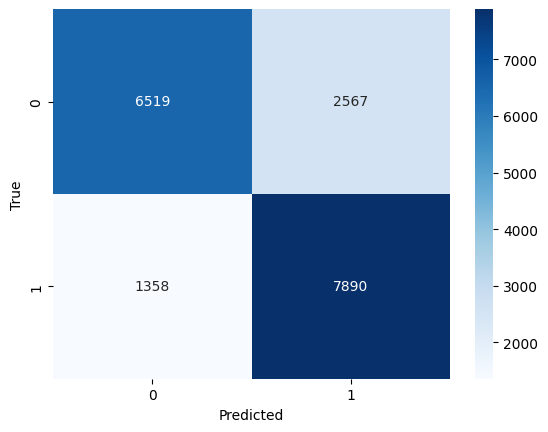

In [20]:
y_pred_modelo_1 = modelo_1.predict(x_test_norm)
y_pred_cat_modelo_1 = np.where(y_pred_modelo_1>0.4, 1, 0)

metricas(y_pred_cat_modelo_1, y_test)

### Modelo 2

In [21]:
# y_pred_model_cv_conexiones = modelo_cv_conexiones.predict(x_test_norm)

# # Devuelve la entrada del diccionario cuyo valor es el menor, lo usamos para obtener el mejor umbral de decisión según train
# def get_highest_boolean_pair(dic):
#     highest_key = 0
#     highest_value = 0
#     for key, value in dic.items():
#         if value > highest_value:
#             highest_key = key
#             highest_value = value
#     return (highest_key, highest_value)

# # Con este snippet, buscamos el valor de umbral de decisión que maximiza f1 para test
# scores = {}
# for i in range(2, 80):
#     minimo = i / 100
#     pred_local = np.where(y_pred_model_cv_conexiones > minimo, 1, 0)
#     scores[minimo] = f1_score(y_test,pred_local)
# mejor_par_minimo = get_highest_boolean_pair(scores)
# print(mejor_par_minimo)

# y_pred_cat_cv = np.where(y_pred_model_cv_conexiones > mejor_par_minimo[0], 1, 0)

# metricas(y_pred_cat_cv, y_test)

### Modelo 3

573/573 [==============================] - 1s 890us/step
(0.48, 0.8528693845754349)
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      9086
           1       0.82      0.89      0.85      9248

    accuracy                           0.85     18334
   macro avg       0.85      0.85      0.85     18334
weighted avg       0.85      0.85      0.85     18334

Precision: 0.8205256320575597
Accuracy: 0.8454783462419548
Recall: 0.8878676470588235
F1-Score: 0.8528693845754349



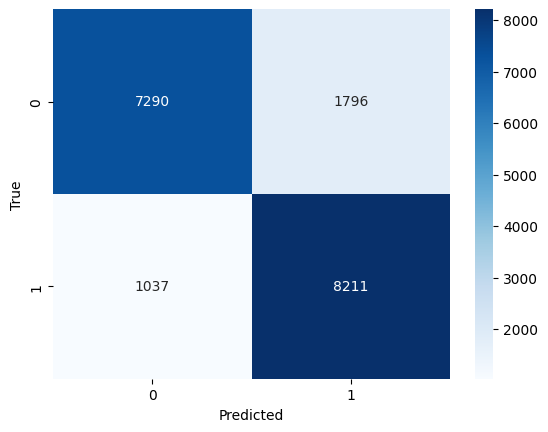

In [22]:
y_pred_model_cv_layers = modelo_cv_layers.predict(x_test_norm)

# Devuelve la entrada del diccionario cuyo valor es el menor, lo usamos para obtener el mejor umbral de decisión según train
def get_highest_boolean_pair(dic):
    highest_key = 0
    highest_value = 0
    for key, value in dic.items():
        if value > highest_value:
            highest_key = key
            highest_value = value
    return (highest_key, highest_value)

# Con este snippet, buscamos el valor de umbral de decisión que maximiza f1 para test
scores = {}
for i in range(2, 80):
    minimo = i / 100
    pred_local = np.where(y_pred_model_cv_layers > minimo, 1, 0)
    scores[minimo] = f1_score(y_test,pred_local)
mejor_par_minimo = get_highest_boolean_pair(scores)
print(mejor_par_minimo)

y_pred_cat_cv = np.where(y_pred_model_cv_layers > mejor_par_minimo[0], 1, 0)

metricas(y_pred_cat_cv, y_test)

## Exportación y submit de modelo

In [31]:
joblib.dump(modelo_cv_layers, '/content/drive/MyDrive/datasetsTP/modelos/modelo_redes_neuronales.joblib')

['/content/drive/MyDrive/datasetsTP/modelos/modelo_redes_neuronales.joblib']

In [28]:
df_submit_basico = generar_df_submit_segun_proba(modelo_1, 0.4)
df_submit_basico.info()

830/830 [==============================] - 1s 829us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.7+ KB


In [25]:
# df_submit_cv_conexiones = generar_df_submit_segun_proba(modelo_cv_conexiones, mejor_par_minimo[0])
# df_submit_cv_conexiones.info()

In [29]:
df_submit_cv_layers = generar_df_submit_segun_proba(modelo_cv_layers, mejor_par_minimo[0])
df_submit_cv_layers.info()

830/830 [==============================] - 1s 938us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.7+ KB


Verificamos que contenga las columnas requeridas y un total de 26535 filas

In [30]:
df_submit_basico.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_redes_neuronales_basico.csv', index = False)
df_submit_cv_layers.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_redes_neuronales_layers.csv', index = False)